In [1]:
import sys
import os
repo_dir = os.path.dirname(os.getcwd())
sys.path.append(repo_dir)

In [2]:
from models.cm import BernoulliDecoder, CLTBernoulliDecoder, ContinuousMixture
from utils.bins_samplers import GaussianQMCSampler
from deeprob.spn.structure.cltree import BinaryCLT
from utils.reproducibility import seed_everything
from models.nets import get_decoder_debd
from torch.utils.data import DataLoader
from utils.datasets import load_debd
import pytorch_lightning as pl
import numpy as np
import torch

device = 'cuda' if torch.cuda.is_available() else 'cpu'
gpus = None if device == 'cpu' else 1
print(device)

cuda


## Hyper-parameters below

In [3]:
max_epochs = 100
batch_size = 128
latent_dim = 16
n_layers = 6
use_clt = True

# every element of the list is a run
n_bins_list = [2**14]
print(n_bins_list)

[16384]


## Load datasets

In [4]:
def encode_class_in_pixels(data, labels):
    class_bits = np.array([[int(b) for b in f"{label:04b}"] for label in labels])
    data[:, -4:] = class_bits
    return data

In [5]:
# 50,000 training and 10,000 validation
train, valid, _ = load_debd('binarized_mnist') # most of the time is taken up here
n_features = train.shape[1] # 784 pixels
print('Shape training:', train.shape, '\nShape valid:', valid.shape, '\nShape test:', _.shape)

# Create data loader
train_loader = DataLoader(train, batch_size=batch_size, shuffle=False, drop_last=True)
valid_loader = DataLoader(valid, batch_size=batch_size)
print('\nLength training loader:', len(train_loader), '\nLength valid loader:', len(valid_loader))

Shape training: (50000, 784) 
Shape valid: (10000, 784) 
Shape test: (10000, 784)

Length training loader: 390 
Length valid loader: 79


In [16]:
print(train.shape)
print(train[0].shape)
print(train)

(50000, 784)
(784,)
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


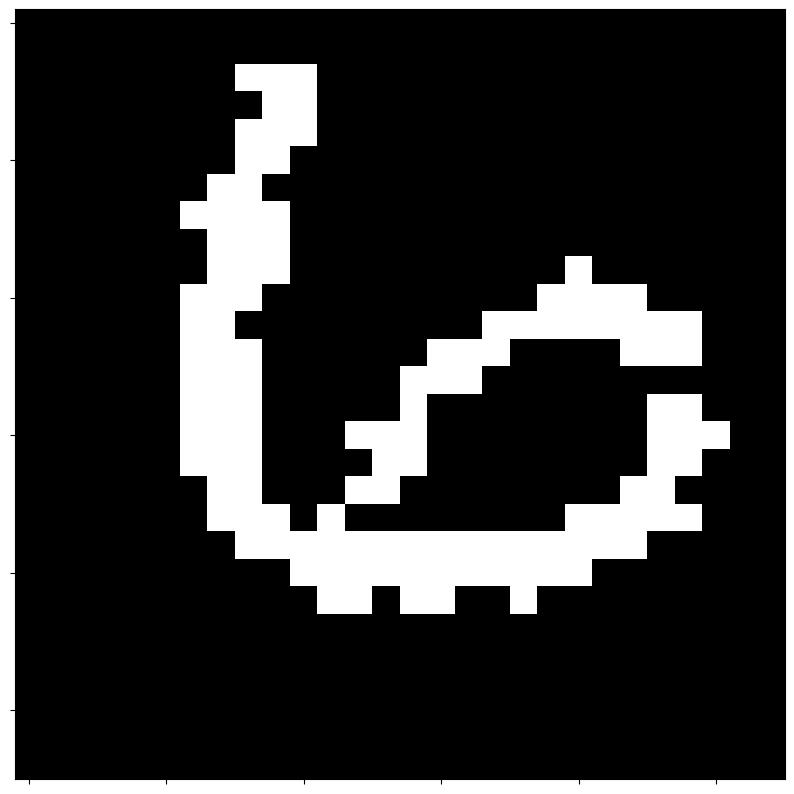

In [6]:
import matplotlib.pyplot as plt
import torchvision

batch_idx, batch = next(iter(enumerate(train_loader)))
# print(batch[0].shape, n_features)

grid_img = torchvision.utils.make_grid(batch[0].view(1, 1, 28, 28), nrow=4)
fig, ax = plt.subplots(1, figsize=(10, 10))
plt.imshow(grid_img.permute(1, 2, 0));
ax.set_yticklabels([]);
ax.set_xticklabels([]);

## Train

In [17]:
# if you run OOM, use n_chunks (e.g. n_chunks = 32)
n_chunks = 32

for n_bins in n_bins_list:
    
        seed_everything(42)
        if use_clt:
            scope = list(range(n_features))
            domain = [[0, 1]] * n_features
            clt = BinaryCLT(scope, root=torch.randint(n_features, (1,)).item())
            clt.fit(train, domain, alpha=0.01)
            decoder = CLTBernoulliDecoder(
                net=get_decoder_debd(
                    latent_dim=latent_dim,
                    out_features=n_features*2,
                    n_layers=n_layers,
                    batch_norm=True),
                tree=list(clt.tree)
            )
        else:
            decoder = BernoulliDecoder(
                net=get_decoder_debd(
                    latent_dim=latent_dim,
                    out_features=n_features,
                    n_layers=n_layers,
                    batch_norm=True)
            )
            
        model = ContinuousMixture(
            decoder=decoder,
            sampler=GaussianQMCSampler(latent_dim, n_bins)
        )
        model.n_chunks = n_chunks
        model.missing = False
        
        cp_best_model_valid = pl.callbacks.ModelCheckpoint(
            save_top_k=1,
            monitor='valid_loss_epoch',
            mode='min',
            filename='best_model_valid-{epoch}'
        )
        early_stop_callback = pl.callbacks.early_stopping.EarlyStopping(
            monitor="valid_loss_epoch", 
            min_delta=0.00, 
            patience=15, 
            verbose=False,
            mode='min'
        )
        callbacks = [cp_best_model_valid, early_stop_callback]
        
        logger = pl.loggers.TensorBoardLogger(repo_dir + '/logs/bmnist/', 'cm_clt/' if use_clt else 'cm_fact/')
        trainer = pl.Trainer(
            max_epochs=max_epochs,
            accelerator='gpu' if gpus and gpus > 0 else 'cpu',
            # gpu=gpus
            devices=gpus if gpus else 1, # corrected
            callbacks=callbacks,
            logger=logger,
            deterministic=True
        )
        print('gpu' if gpus and gpus > 0 else 'cpu', gpus if gpus else 1)
        trainer.fit(model, train_loader, valid_loader)

tensor([  16,  274,  532,  790, 1048, 1306], dtype=torch.int32)


/home2/s3313093/venvs/my_env/lib/python3.10/site-packages/pytorch_lightning/utilities/parsing.py:208
/home2/s3313093/venvs/my_env/lib/python3.10/site-packages/lightning_fabric/plugins/environments/slurm.py:204
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


gpu 1



  | Name    | Type                | Params | Mode 
--------------------------------------------------------
0 | decoder | CLTBernoulliDecoder | 4.8 M  | train
--------------------------------------------------------
4.8 M     Trainable params
0         Non-trainable params
4.8 M     Total params
19.313    Total estimated model params size (MB)
18        Modules in train mode
0         Modules in eval mode

Detected KeyboardInterrupt, attempting graceful shutdown ...


NameError: name 'exit' is not defined